In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Data
reference: https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook


In [4]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
# dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

dataPath = '/content/drive/MyDrive/bill/home-credit-credit-risk-model-stability/'

In [5]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

# Train data read from csv

In [6]:
### Base Table:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")

### FEATURES
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)

train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

### delete this cell (only for reference)

In [7]:
PATH_BASE_TRAIN = f'{dataPath}csv_files/train/train_base.csv'
PATH_BASE_TEST = f'{dataPath}/csv_files/test/test_base.csv'

train =  pd.read_csv(PATH_BASE_TRAIN)
test =   pd.read_csv(PATH_BASE_TEST)

display(train.head(3))
display(test.head(3))
display(train.dtypes)

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0


,case_id,date_decision,MONTH,WEEK_NUM
0,57543,2020-10-06,202010,92
1,57549,2020-10-06,202010,92
2,57551,2020-10-06,202010,92


case_id           int64
date_decision    object
MONTH             int64
WEEK_NUM          int64
target            int64
dtype: object

In [8]:
display(train_basetable.head(3))
# display(test.head(3))
display(train_basetable.dtypes)
print(train_credit_bureau_b_2.columns)
print(train_person_1.columns)
print(train_static_cb.columns)
print(train_static.columns)
print(train_basetable.columns)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0


[Int64, Utf8, Int64, Int64, Int64]

['case_id', 'num_group1', 'num_group2', 'pmts_date_1107D', 'pmts_dpdvalue_108P', 'pmts_pmtsoverdue_635A']
['case_id', 'birth_259D', 'birthdate_87D', 'childnum_185L', 'contaddr_district_15M', 'contaddr_matchlist_1032L', 'contaddr_smempladdr_334L', 'contaddr_zipcode_807M', 'education_927M', 'empl_employedfrom_271D', 'empl_employedtotal_800L', 'empl_industry_691L', 'empladdr_district_926M', 'empladdr_zipcode_114M', 'familystate_447L', 'gender_992L', 'housetype_905L', 'housingtype_772L', 'incometype_1044T', 'isreference_387L', 'language1_981M', 'mainoccupationinc_384A', 'maritalst_703L', 'num_group1', 'personindex_1023L', 'persontype_1072L', 'persontype_792L', 'registaddr_district_1083M', 'registaddr_zipcode_184M', 'relationshiptoclient_415T', 'relationshiptoclient_642T', 'remitter_829L', 'role_1084L', 'role_993L', 'safeguarantyflag_411L', 'sex_738L', 'type_25L']
['case_id', 'assignmentdate_238D', 'assignmentdate_4527235D', 'assignmentdate_4955616D', 'birthdate_574D', 'contractssum_5085716

In [9]:
print(len(train_credit_bureau_b_2.columns) + len(train_person_1.columns)
+ len(train_static_cb.columns ))

96


In [10]:
# # prompt: Left join equivalent function in  the polaris dataframes, after converting to pandas,  on case_id train_credit_bureau_b_2 print(train_person_1) print(train_static_cb) print(train_static) print(train_basetable)

# train_credit_bureau_b_2_pd = train_credit_bureau_b_2.to_pandas()
# train_person_1_pd = train_person_1.to_pandas()
# train_static_cb = train_static_cb.to_pandas()
# train_static = train_static.to_pandas()
# train_basetable = train_basetable.to_pandas()

# join_df = pd.merge(train_basetable, train_credit_bureau_b_2, on='case_id', how='left')
# join_df = pd.merge(join_df, train_person_1, on='case_id', how='left')



In [11]:
# print(len(pd.unique(join_df['case_id'])))
# print(len(join_df))
# print(len(train_credit_bureau_b_2), len(pd.unique(train_credit_bureau_b_2['case_id'])))
# # print(len(train_person_1.columns), len(pd.unique(train_person_1['case_id'])))
# print(len(train_basetable), len(pd.unique(train_basetable['case_id'])))

In [12]:
# join_df_2 = pd.merge(train_basetable, train_static, on='case_id', how='left')

In [13]:
# print(len(join_df_2), len(pd.unique(join_df_2)))

In [14]:
# join_df_3 = pd.merge(train_basetable, train_static_cb, on='case_id', how='left')


# print(join_df)

# Train Data

In [15]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

This joins
1. train_basetable,
2. train_static, train_static_cb,
3. train_person_1_feats_1,
4. train_person_1_feats_2, and
5. train_credit_bureau_b_2_feats

DataFrames on "case_id" column using left joins.

Total of case_id is 1526659 with no dups. There few things I want to verify for the base file before I am done with it:



1.   Check if any dates are missing in date_decision;
2.   Check the target counts.
3.   Check the
target distibutions against year/month of date_decision.

# [READING TEST DATA CSV]

TEST READ CSV

In [17]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# TEST DATA

In [18]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

# Polaris to pandas




In [16]:
# data => shape: (1_526_659, 58)
data.head(3)

case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
0,"""2019-01-03""",201901,0,0,null,1917.6,0.0,null,null,null,null,30000.0,0.0,0.0,30000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10800.0,false,null,null,null
1,"""2019-01-03""",201901,0,0,null,3134.0,0.0,null,null,null,null,19999.8,0.0,0.0,19999.8,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
2,"""2019-01-04""",201901,0,0,null,4937.0,0.0,null,null,null,null,78000.0,0.0,0.0,78000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",10000.0,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,14000.0,false,null,null,null


In [19]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

# Data exploration

In [55]:
# train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")


data_pd = data.to_pandas()
'''
# similarly data_pd can be thought to be similar to pd.read_csv("base_train_path")
# in functionality, but with additional columns from all other csv files.
'''
train_basetable_pd = pd.read_csv(dataPath + "csv_files/train/train_base.csv")

# print(data_pd.head())
print(len(data_pd.columns),len(train_basetable_pd.columns))
print(data_pd.shape, train_basetable_pd.shape)

""" And
base_train, X_train, y_train are the train-test split of data or data_pd
"""

SyntaxError: incomplete input (<ipython-input-55-0a00851f99c6>, line 13)

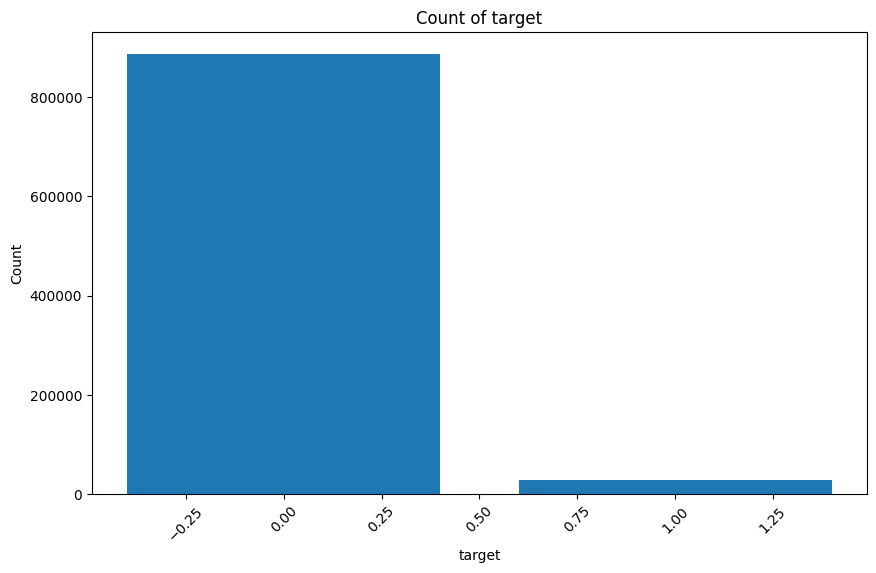

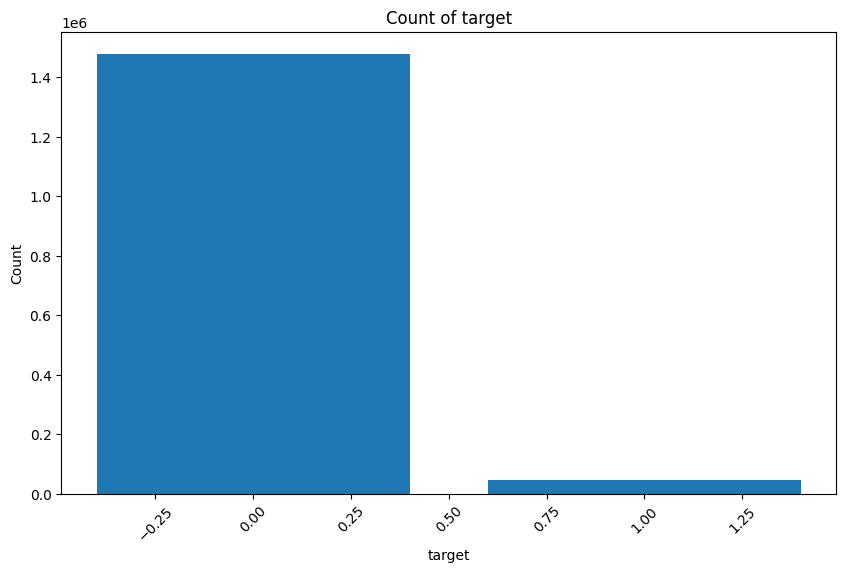

In [49]:
import matplotlib.pyplot as plt

data_train_total = data_pd


def plot_count(data, columns):
    for col in columns:
        value_counts = data[col].value_counts()
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts.index, value_counts.values)
        plt.title(f'Count of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Example usage:
plot_count(base_train, ['target'])
plot_count(data_pd, ['target'])


In [ ]:
from plot_utils import piechart
from plot_utils import plot_count
# from utils import plot_count

plot_count(data, ['target'])

# case_ids = data["case_id"].unique().shuffle(seed=1)
print(len(case_ids))  # 1526659 unique case ids


In [47]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [ ]:
# def get_date_interval_info(df, cS):
#     df['date_decision'] = pd.to_datetime(df['date_decision'])
#     date_delta = df['date_decision'].drop_duplicates().sort_values().diff()
#     len_uniq_dates = len(df.date_decision.unique())
#     print(
#         f'\n{cS.blk}[INFO] Actual date range:  {cS.red}{date_delta.sum().days + 1} day(s).',
#         f'\n{cS.blk}[INFO] Total unique dates: {cS.red}{len_uniq_dates} day(s).'
#     )

#     print(f'\n{cS.blk}[INFO] Min date: {cS.red}{df.date_decision.dt.date.min()}',
#           f'\n{cS.blk}[INFO] Max date: {cS.red}{df.date_decision.dt.date.max()}')

# get_date_interval_info(data)
# !printf  "\n----------Test data----------\n"
# get_date_interval_info(data_submission, cS)

In [ ]:
print(len(cols_pred))